# Phase transition experiments for 1-D TV using Mosek

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import numpy.random as rnd
import mosek
import mosek.fusion
from mosek.fusion import *
import sys
import time
import matplotlib.pyplot as plt
import pickle

In [2]:
# Basic parameters of the problem
d = 100
D = (-np.eye(d)+np.eye(d,k=1))[:d-1,:]
I = np.eye(d)

In [3]:
def gen_tv_signal(d,s):
    signs = np.sign(rnd.randn(s))
    dx = rnd.permutation(np.concatenate((signs,np.zeros(d-s-1))))
    x = np.concatenate(([0.], np.cumsum(dx)))
    return x

In [4]:
def gen_sparse_signal(d,s):
    signs = np.sign(rnd.randn(s))
    x = rnd.permutation(np.concatenate((signs,np.zeros(d-s))))
    return x

In [5]:
def gen_monotone_signal(d,s):
    dx = rnd.permutation(np.concatenate((np.ones(s),np.zeros(d-s-1))))
    x = np.concatenate(([0.],np.cumsum(dx)))
    return x

In [6]:
def gen_alt_signal(d,s):
    dx = rnd.permutation(np.concatenate((np.ones(s),np.zeros(d-s-1))))
    sgn = 1.
    for i in range(d-1):
        if dx[i] != 0:
            dx[i] *= sgn
            sgn *= -1.
    x = np.concatenate(([0.],np.cumsum(dx)))
    return x

In [7]:
def phase_diagram(d, step, signal_generator, D, T=100, bounds=None, inputdiagram=None):
    tstart = time.time()
    n = D.shape[0]
    e = np.ones(n)
    if inputdiagram is None:
        # Allow for adding to an already computed diagram
        diagram = np.zeros((int(d/step),int(d/step)))
    else:
        diagram = inputdiagram.copy()
    if bounds is None:
        # Allow for specifying lower and upper bounds for the number of measurements for each sparsity level
        bounds = np.ones((2,d), np.int32)
        bounds[1,:] = d*np.ones(d)
    for t in range(T):
        # The outer loop is over the number of random measurement matrices / saves time on generating random matrices
        if not t%10:
            tt = time.time()
        A = rnd.randn(d,d)
        for s in range(step,d,step):
            x0 = signal_generator(d,s)
            y = np.dot(A,x0)
            with  Model("Basic") as M:
                M.setSolverParam("optimizer", "freeSimplex")
                z = M.variable("z", NDSet(n,1), Domain.greaterThan(0.0))
                x = M.variable("x", NDSet(d,1), Domain.unbounded())
                M.constraint('left', Expr.sub(z,Expr.mul(D,x)), Domain.greaterThan(0.0));
                M.constraint('right', Expr.add(Expr.mul(D,x),z), Domain.greaterThan(0.0)); 
                M.objective('obj', ObjectiveSense.Minimize, Expr.dot(e,z))
                M.constraint(Expr.mul(A[:bounds[0,s]-step,:],x), Domain.equalsTo(y[:bounds[0,s]-step]))
                for m in range(bounds[0,s],bounds[1,s],step):
                    M.constraint(Expr.mul(A[m-step:m,:],x), Domain.equalsTo(y[m-step:m]))
                    M.solve()
                    res = x.level()
                    if la.norm(res-x0)/la.norm(x0)<1e-8:
                        diagram[int(m/step)-1,int(s/step)-1] += 1.
            for m in range(bounds[1,s],d,step):
                diagram[int(m/step)-1,int(s/step)-1] += 1.
        if not (t+1)%10:
            elapsed = time.time()-tt
            print("Iterations:", t+1,"Time: ", elapsed)
    totaltime = time.time()-tstart
    print("Total time:", totaltime)
    return(diagram)

### Phase transition experiments for TV regularization

We first load some upper and lower bounds on the number of measurements, so that for each sparsity $s$, the "interesting" region of the phase transition diagram is between those bounds. This ensures that we don't waste our time computing the success probabilities in regions where this is 0 or 1. These bounds were computed by running the phase transition generator at lower resolution.

In [8]:
pickle_in = open("tvbounds.pickle","rb")
tvbounds = pickle.load(pickle_in)
pickle_in.close()

In [9]:
pickle_in = open("tvphase_raw.pickle","rb")
tvdiagram_raw = pickle.load(pickle_in)
pickle_in.close()

In [10]:
tvdiagram_raw = phase_diagram(d=100, step=1, signal_generator=gen_tv_signal, D=D, T=100, bounds=tvbounds, inputdiagram=tvdiagram_raw)
tvdiagram = tvdiagram_raw/np.max(tvdiagram_raw)

Iterations: 10 Time:  856.8679113388062
Iterations: 20 Time:  476.0204071998596
Iterations: 30 Time:  8384.4187271595
Iterations: 40 Time:  402.71553587913513
Iterations: 50 Time:  407.3588228225708
Iterations: 60 Time:  429.00545287132263
Iterations: 70 Time:  451.8121757507324
Iterations: 80 Time:  442.8302147388458
Iterations: 90 Time:  401.63841676712036
Iterations: 100 Time:  414.8301215171814
Total time: 12667.50176858902


In [11]:
# Save for later use
pickle_out = open("tvphase_raw.pickle","wb")
pickle.dump(tvdiagram_raw, pickle_out)
pickle_out.close()

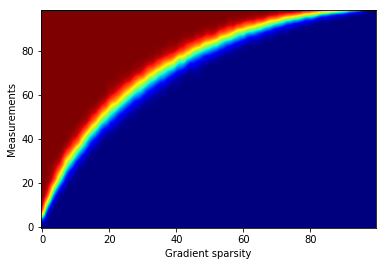

In [12]:
plt.imshow(tvdiagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
plt.xlabel("Gradient sparsity")
plt.ylabel("Measurements")
#plt.savefig("tvphase.png")
plt.show()

In [13]:
# Save for later use
pickle_out = open("tvphase.pickle","wb")
pickle.dump(tvdiagram, pickle_out)
pickle_out.close()

In [14]:
# Compute the upper and lower bounds for the "intersting region" and record them
tvbounds = np.zeros((2,d), np.int32)
for i in range(d):
    tvbounds[0,i] = max(np.searchsorted(tvdiagram[:,i],0,side='right')-5,1)
    tvbounds[1,i] = min(np.searchsorted(tvdiagram[:,i],1,side='left')+5,d)
pickle_out = open("tvbounds.pickle","wb")
pickle.dump(tvbounds, pickle_out)
pickle_out.close()

### Phase transition experiments for $\ell_1$ regularization

In [15]:
pickle_in = open("l1bounds.pickle","rb")
l1bounds = pickle.load(pickle_in)
pickle_in.close()

In [16]:
pickle_in = open("l1phase_raw.pickle","rb")
l1diagram_raw = pickle.load(pickle_in)
pickle_in.close()

In [17]:
l1diagram_raw = phase_diagram(d=100, step=1, signal_generator=gen_sparse_signal, D=I, T=100, bounds=l1bounds, inputdiagram=l1diagram_raw)
l1diagram = l1diagram_raw/np.max(l1diagram_raw)

Iterations: 10 Time:  441.85086250305176
Iterations: 20 Time:  390.2898600101471
Iterations: 30 Time:  349.45104241371155
Iterations: 40 Time:  345.21039485931396
Iterations: 50 Time:  343.71039938926697
Iterations: 60 Time:  349.42511320114136
Iterations: 70 Time:  343.3633313179016
Iterations: 80 Time:  345.09370040893555
Iterations: 90 Time:  342.1984484195709
Iterations: 100 Time:  346.87493562698364
Total time: 3597.472076654434


In [18]:
# Save for later use
pickle_out = open("l1phase_raw.pickle","wb")
pickle.dump(l1diagram_raw, pickle_out)
pickle_out.close()

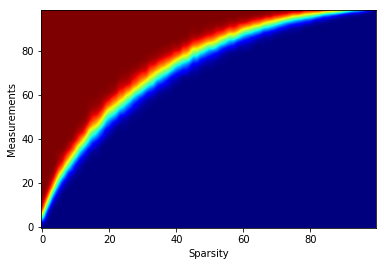

In [19]:
# Plot alongside TV diagram
plt.imshow(l1diagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
plt.xlabel("Sparsity")
plt.ylabel("Measurements")
#plt.savefig("l1phase.png")
plt.show()

In [20]:
# Save for later use
pickle_out = open("l1phase.pickle","wb")
pickle.dump(l1diagram, pickle_out)
pickle_out.close()

In [21]:
# Compute the upper and lower bounds for the "intersting region" and record them
l1bounds = np.zeros((2,d), np.int32)
for i in range(d):
    l1bounds[0,i] = max(np.searchsorted(l1diagram[:,i],0,side='right')-5,1)
    l1bounds[1,i] = min(np.searchsorted(l1diagram[:,i],1,side='left')+5,d)
pickle_out = open("l1bounds.pickle","wb")
pickle.dump(l1bounds, pickle_out)
pickle_out.close()

### Phase transition experiments for TV and monotone signals

In [22]:
pickle_in = open("monotonebounds.pickle","rb")
monotonebounds = pickle.load(pickle_in)
pickle_in.close()

In [23]:
pickle_in = open("monotonephase_raw.pickle","rb")
monotonediagram_raw = pickle.load(pickle_in)
pickle_in.close()

In [24]:
monotonediagram_raw = phase_diagram(d=100, step=1, signal_generator=gen_monotone_signal, D=D, T=100, bounds=monotonebounds, inputdiagram=monotonediagram_raw)
monotonediagram = monotonediagram_raw/np.max(monotonediagram_raw)

Iterations: 10 Time:  373.29724383354187
Iterations: 20 Time:  368.10612988471985
Iterations: 30 Time:  368.9508726596832
Iterations: 40 Time:  368.56989097595215
Iterations: 50 Time:  366.6161186695099
Iterations: 60 Time:  401.00610971450806
Iterations: 70 Time:  367.60746359825134
Iterations: 80 Time:  367.7012183666229
Iterations: 90 Time:  368.0582580566406
Iterations: 100 Time:  369.491427898407
Total time: 3719.4097199440002


In [25]:
# Save for later use
pickle_out = open("monotonephase_raw.pickle","wb")
pickle.dump(monotonediagram_raw, pickle_out)
pickle_out.close()

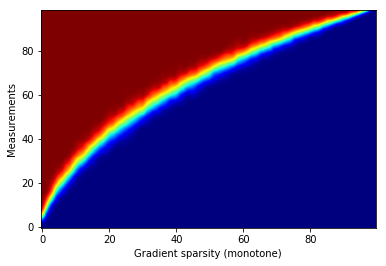

In [26]:
plt.imshow(monotonediagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
plt.xlabel("Gradient sparsity (monotone)")
plt.ylabel("Measurements")
#plt.plot(monotonebounds[0,:])
#plt.plot(monotonebounds[1,:])
#plt.savefig("tvphase.png")
plt.show()

In [27]:
# Save for later use
pickle_out = open("monotonephase.pickle","wb")
pickle.dump(monotonediagram, pickle_out)
pickle_out.close()

In [28]:
# Compute the upper and lower bounds for the "intersting region" and record them
monotonebounds = np.zeros((2,d), np.int32)
for i in range(d):
    monotonebounds[0,i] = max(np.searchsorted(monotonediagram[:,i],0,side='right')-10,1)
    monotonebounds[1,i] = min(np.searchsorted(monotonediagram[:,i],1,side='left')+10,d)
pickle_out = open("monotonebounds.pickle","wb")
pickle.dump(monotonebounds, pickle_out)
pickle_out.close()

### Phase transition experiments for TV and maximally oscillating signals

In [29]:
pickle_in = open("maxbounds.pickle","rb")
maxbounds = pickle.load(pickle_in)
pickle_in.close()

In [30]:
pickle_in = open("maxphase_raw.pickle","rb")
maxdiagram_raw = pickle.load(pickle_in)
pickle_in.close()

In [31]:
maxdiagram_raw = phase_diagram(d=100, step=1, signal_generator=gen_alt_signal, D=D, T=100, bounds=maxbounds, inputdiagram=maxdiagram_raw)
maxdiagram = maxdiagram_raw/np.max(maxdiagram_raw)

Iterations: 10 Time:  447.12371945381165
Iterations: 20 Time:  487.4338722229004
Iterations: 30 Time:  495.3237295150757
Iterations: 40 Time:  1085.2118005752563
Iterations: 50 Time:  442.00641202926636
Iterations: 60 Time:  437.1204869747162
Iterations: 70 Time:  435.685320854187
Iterations: 80 Time:  449.59610748291016
Iterations: 90 Time:  447.1715898513794
Iterations: 100 Time:  444.3611114025116
Total time: 5171.03813958168


In [32]:
# Save for later use
pickle_out = open("maxphase_raw.pickle","wb")
pickle.dump(maxdiagram_raw, pickle_out)
pickle_out.close()

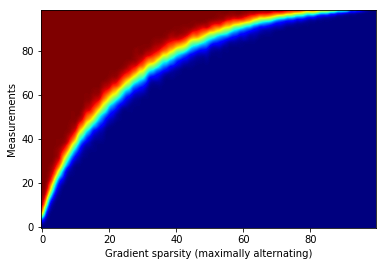

In [33]:
plt.imshow(maxdiagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
plt.xlabel("Gradient sparsity (maximally alternating)")
plt.ylabel("Measurements")
#plt.savefig("tvphase.png")
plt.show()

In [34]:
# Save for later use
pickle_out = open("maxphase.pickle","wb")
pickle.dump(maxdiagram, pickle_out)
pickle_out.close()

In [35]:
# Compute the upper and lower bounds for the "intersting region" and record them
maxbounds = np.zeros((2,d), np.int32)
for i in range(d):
    maxbounds[0,i] = max(np.searchsorted(maxdiagram[:,i],0,side='right')-15,1)
    maxbounds[1,i] = min(np.searchsorted(maxdiagram[:,i],1,side='left')+15,d)
pickle_out = open("maxbounds.pickle","wb")
pickle.dump(maxbounds, pickle_out)
pickle_out.close()

### Plot all phase transition diagrams next to each other

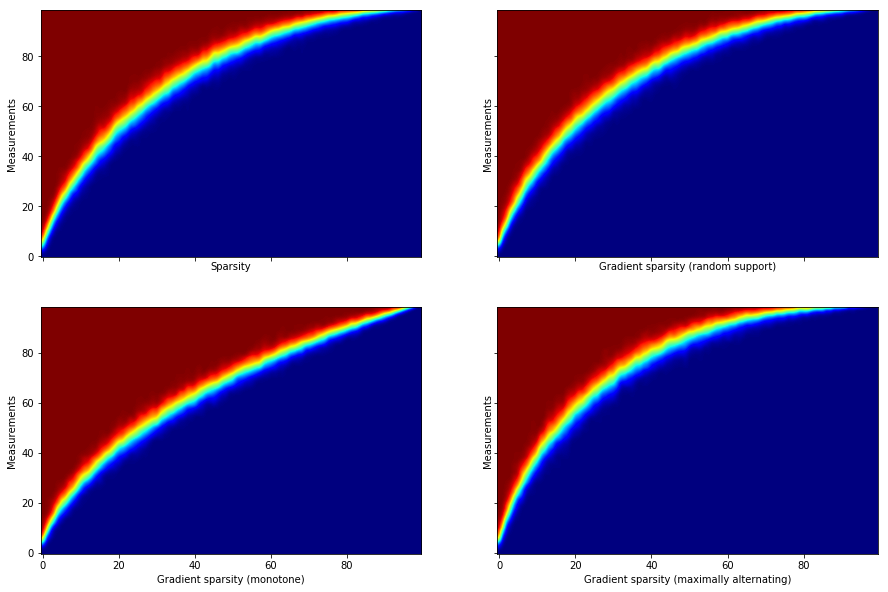

In [36]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,10))
# 1-norm minimization with arbitrary sparse vector
ax[0,0].imshow(l1diagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
ax[0,0].set_xlabel("Sparsity")
ax[0,0].set_ylabel("Measurements")
# TV norm minimization with random signals with sparse gradient
ax[0,1].imshow(tvdiagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
ax[0,1].set_xlabel("Gradient sparsity (random support)")
ax[0,1].set_ylabel("Measurements")
# TV norm minimization with monotone signals
ax[1,0].imshow(monotonediagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
ax[1,0].set_xlabel("Gradient sparsity (monotone)")
ax[1,0].set_ylabel("Measurements")
# TV norm minimization with maximally alternating signals
ax[1,1].imshow(maxdiagram[:-1,:], origin='lower', cmap='jet', interpolation='bicubic', aspect='auto')
ax[1,1].set_xlabel("Gradient sparsity (maximally alternating)")
ax[1,1].set_ylabel("Measurements")
plt.savefig("tvphase.png")